16 дисков радиусом $\sigma$ = 1 находятся в квадратном
коробе размера Lx = Ly = 10 с зеркальными граничными условиями (диски отталкиваются от стенок, как бильярдные шары). Задайте случайное расположение частиц так,
чтобы они не накладывались друг на друга (или задайте гранецентрированное положение частиц). Задайте каждой частице скорость так, чтобы модуль скорости был равен 1,
а направление было случайное. Напишите функцию расчета минимального времени до
столкновения τcoll. Проведите моделирование в течение $10^6$ шагов (столкновений).
## Постройте график распределения расстояний между частицами

In [1]:
import random, math
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

### Инициализируем начальние координаты точек. 
Условие неналожения: $|\Delta \textbf{r}_{ij}|>\sigma$.

In [2]:
N = 16 
sigma = 0.2
L = 10
condition = False
while condition == False:
    coor = [(random.uniform(sigma, L - sigma), random.uniform(sigma, L - sigma))]
    for k in range(1, N):
        a = (random.uniform(sigma, L - sigma), random.uniform(sigma, L - sigma))
        min_dist = min(math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2) for b in coor) 
        if min_dist < 2.0 * sigma: 
            condition = False
            break
        else:
            coor.append(a)
            condition = True
#print (coor)

### Инициализация начальных скоростей
Случайная величина - угол между вектором скоростей и осью OX

In [3]:
vel = []
for k in range(N):
    phi = math.radians(random.uniform(0, 360))
    v = (math.cos(phi), math.sin(phi))
    vel.append(v)
#vel

In [4]:
def curr_state(coor, vel):     # возращает текущее состояние частиц (x, y, vx, vy)
    v_ = np.asarray(vel)
    o_ = np.asarray(coor)
    state = np.hstack((o_,v_))
    return state

initial_state = curr_state(coor, vel)
#initial_state

### Время до столкновенея

In [5]:
def wall_time(coor, vel):
    if vel[0] > 0.0:
        del_tr = (L - sigma - coor[0]) / vel[0]
        del_tl = float('inf')
    elif vel[0] < 0.0:
        del_tl = (coor[0] - sigma) / abs(vel[0])
        del_tr = float('inf')
    if vel[1] > 0.0:
        del_tt = (L - sigma - coor[1]) / vel[1]
        del_td = float('inf')
    elif vel[1] < 0.0:
        del_td = (coor[1] - sigma) / abs(vel[1])
        del_tt = float('inf')
    return [del_tt, del_tr, del_td, del_tl]


wall_time(coor[0], vel[0])

[9.75013319242747, 20.130915789656555, inf, inf]

In [9]:
def pair_time(pos_a, vel_a, pos_b, vel_b):
    del_x = [pos_b[0] - pos_a[0], pos_b[1] - pos_a[1]]
    del_x_sq = del_x[0] ** 2 + del_x[1] ** 2
    del_v = [vel_b[0] - vel_a[0], vel_b[1] - vel_a[1]]
    del_v_sq = del_v[0] ** 2 + del_v[1] ** 2
    scal = del_v[0] * del_x[0] + del_v[1] * del_x[1]
    d = scal ** 2 - del_v_sq * (del_x_sq - 4.0 * sigma ** 2)
    x = math.sqrt(del_x_sq)
    if d > 0.0 and scal < 0.0:
        del_t = - (scal + math.sqrt(d)) / del_v_sq
    else:
        del_t = float('inf')
    return del_t, x
pair_time(coor[0],vel[0], coor[1], vel[1])

(inf, 4.93828774694499)

### Кофигурации пар без повторения

In [10]:
pairs = []
for i in range(N-1):
    for j in range(i+1, N):
        pairs.append((i, j))
len(pairs)

120

### Подсчет минимального времени до столкновений

In [12]:
def next_coll(state):
    coor, vel = np.split(state, 2, axis=1)
    t_walls = []
    t_pairs = np.array(float("inf"))*np.ones((N,N))
    x = []
    for i in range(N):
        t_walls.append(wall_time(coor[i], vel[i]))
    for i, j in pairs:
        t_pairs[i][j], dx = pair_time(coor[i], vel[i], coor[j], vel[j])
        x.append(dx)
        t_pairs[j][i] = t_pairs[i][j]
    t_coll = np.hstack((t_pairs, t_walls))
    t_min = t_coll.min()
    i, j = np.where(t_coll==t_min)
    i = i[0]
    j = j[0]
    return i, j, t_min , x
#next_coll(initial_state)


In [13]:
def next_state(i, j, t_min, curr_state): # обновляет текущее состояние частиц (x, y, vx, vy)
    o, v = np.split(curr_state, 2, axis=1)
    o_next = o+v*t_min
    
    w = 0
    #change direction. New v
    if j >= N:
        #v[i][0] = -v[i][0] # X
        #v[i][1] = -v[i][1] # Y
        w = 1
        
        if (j == N) or (j == (N+2)):  # Top or Bottom
            v[i][1] = -v[i][1] # Y
        else:
            if (j == (N+1)) or (j == (N+3)): # Right or Left
                v[i][0] = -v[i][0] # X
    else:
        
        oxi, oyi = o_next[i]
        oxj, oyj = o_next[j]
        vxi, vyi = v[i]
        vxj, vyj = v[j] 
        dvx = vxj-vxi
        dvy = vyj-vyi
        dox = oxj-oxi
        doy = oyj-oyi
        abs_ = (dox**2+doy**2)**0.5
        #abs_v = (dvx**2+dvy**2)**0.5
        dox = dox/abs_
        doy = doy/abs_
        dvdo = dvx*dox + dvy*doy
        J = dvdo
        Jx = J*dox
        Jy = J*doy
        
        v[i][0] = (vxi+Jx) #change xi
        v[i][1] = (vyi+Jy) #change yi
        v[j][0] = (vxj-Jx) #change xj
        v[j][1] = (vyj-Jy) #change yj
        
    
    
    next_state = np.hstack((o_next,v))
    return next_state, w
#next_state(1, 2, 0.16, initial_state)

In [14]:
st = time.time()

c = 0     # кол-во столкновений
t_coll = [] # время до столкновения
abs_v = [] # модули скорости
del_ = [] # проекции скорости на У
w = 0

state = initial_state
while c < 100000:
    i, j, t, x = next_coll(state)
    state, w_ = next_state(i,j,t,state)
    o, vv = np.split(state, 2, axis=1)  
    t_coll += [t]
    t_ = sum(t_coll)  # общее время эксперимента
    c += 1
    w += w_
    for i in range(len(x)):
        del_ += [x[i]]
    
end_ = time.time() - st
print('Wall_colls', w,
      '\nNumber of Collisions:',c, 
      '\nCollision time:',t_,
      '\nProgram runtime:',end_, 
      's\nCurrent state:\n',state,'\n')

Wall_colls 60403 
Number of Collisions: 100000 
Collision time: 30569.7687823126 
Program runtime: 695.4426362514496 s
Current state:
 [[ 5.0753326   9.22608414  0.41145367  0.16987034]
 [ 9.73146406  0.56037927  0.46661978 -0.75896   ]
 [ 2.19896053  8.76048085 -0.22485222 -0.14455879]
 [ 4.55820895  8.72711483  0.32985797  0.16449959]
 [ 5.35913102  7.86672346  2.06257306 -0.61376285]
 [ 2.01515035  7.74389084 -0.02574029  0.06067379]
 [ 1.0556151   0.2        -0.23068081  0.57098313]
 [ 7.59204672  6.73743074 -0.85519731 -0.52281514]
 [ 0.48061188  6.37159519  0.76395336  0.91438028]
 [ 5.88273804  2.73275628 -0.27338097 -0.25444874]
 [ 4.22002169  4.78574427  0.40863311 -1.20490636]
 [ 6.95297431  6.65795092 -1.36332025  1.47614348]
 [ 8.51660599  2.99397547 -0.23974513 -0.30706698]
 [ 4.10979487  7.00122248  0.77541441  0.23004646]
 [ 6.34945284  8.91307121 -0.46130861  0.70087962]
 [ 4.50670165  8.3283637   0.07691647 -0.22372653]] 



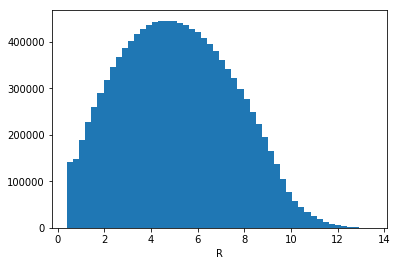

In [15]:
plt.hist(del_, bins=50)
plt.xlabel('R')
plt.show()